<a href="https://colab.research.google.com/github/chlai1012/ML-project/blob/chlai_colab/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Prepare training data**

In [ ]:
!wget --no-check-certificate \
    "https://github.com/chlai1012/ML-project/archive/refs/heads/chlai_folder_correct.zip" \
    -O "/tmp/ML-project-chlai_folder_correct.zip"

zip_ref = zipfile.ZipFile('/tmp/ML-project-chlai_folder_correct.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-08-11 18:19:37--  https://github.com/chlai1012/ML-project/archive/refs/heads/chlai_folder_correct.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/chlai1012/ML-project/zip/refs/heads/chlai_folder_correct [following]
--2021-08-11 18:19:37--  https://codeload.github.com/chlai1012/ML-project/zip/refs/heads/chlai_folder_correct
Resolving codeload.github.com (codeload.github.com)... 140.82.112.9
Connecting to codeload.github.com (codeload.github.com)|140.82.112.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/ML-project-chlai_folder_correct.zip’

/tmp/ML-project-chl     [  <=>               ]   2.14M  4.71MB/s    in 0.5s    

2021-08-11 18:19:38 (4.71 MB/s) - ‘/tmp/ML-project-chlai_folder_correct.zip’ saved [2243998]



In [ ]:
hsLen = len(os.listdir('/tmp/ML-project-chlai_folder_correct/Heat source/Data'))
gtLen = len(os.listdir('/tmp/ML-project-chlai_folder_correct/Ground truth/Data'))

print('Heat source: ' , hsLen) # Get sample length from folders
print('Ground truth: ' , gtLen)

Heat source:  121
Ground truth:  121


In [ ]:
image_generator = ImageDataGenerator()

# fixed RNG seed to make sure images and masks are transformed in the same way
seed = 42

hs_iterator = image_generator.flow_from_directory("/tmp/ML-project-chlai_folder_correct/Heat source",
                          class_mode=None,
                          batch_size=16, 
                          seed=seed)

gt_iterator = image_generator.flow_from_directory("/tmp/ML-project-chlai_folder_correct/Ground truth",
                          class_mode=None,
                          batch_size=16, 
                          seed=seed)

train_iterator = zip(hs_iterator, gt_iterator)

Found 121 images belonging to 1 classes.
Found 121 images belonging to 1 classes.


In [ ]:
hs, gt= next(train_iterator)
hs.shape

(16, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

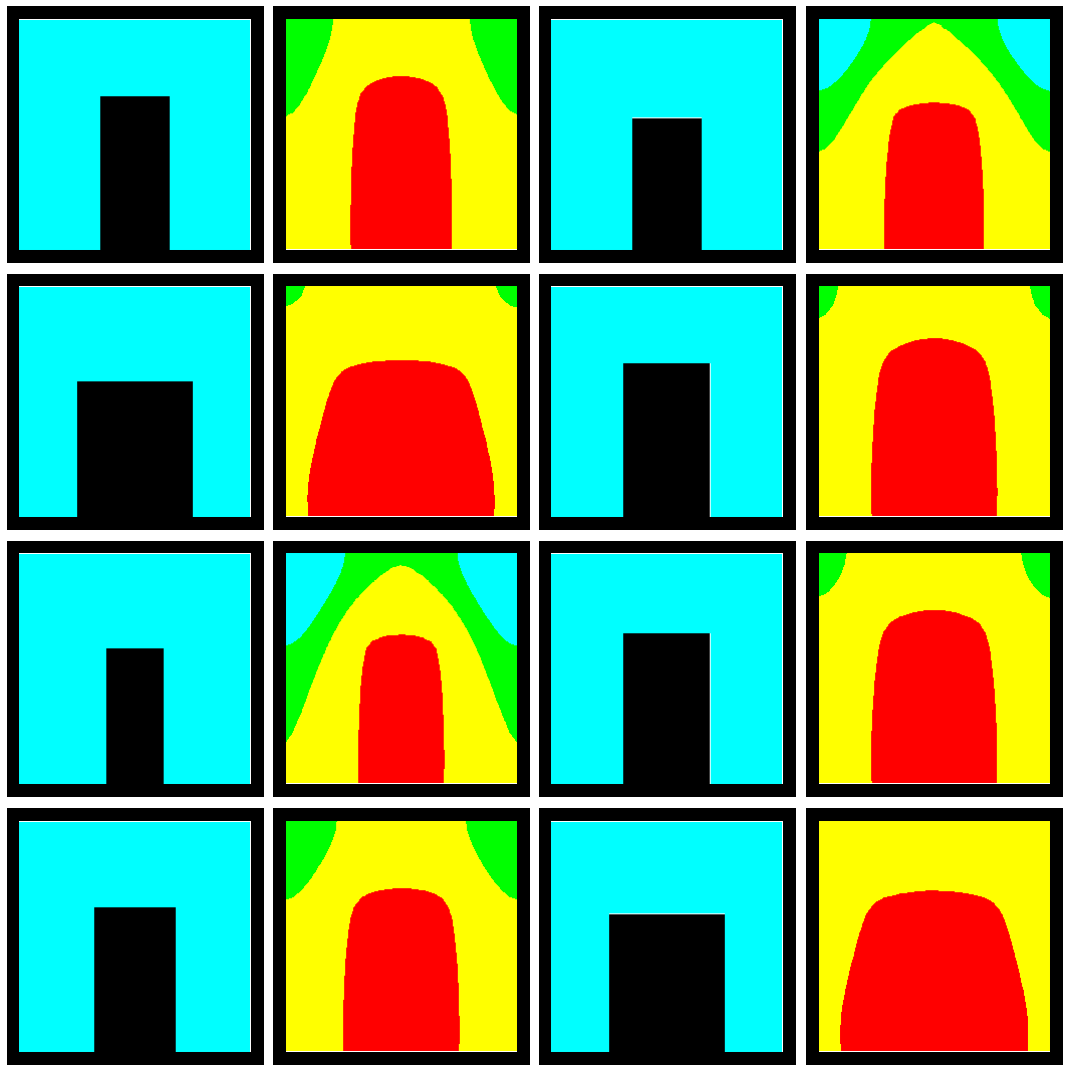

In [ ]:
fig,axs = plt.subplots(4,4, figsize=(15,15))
axs = axs.flatten()

hs, gt= next(train_iterator)

for i in range(8):
    axs[2*i].imshow(hs[i])
    axs[2*i+1].imshow(gt[i])
    
for ax in axs:
    ax.axis("off")

plt.tight_layout()

**CNN**

In [ ]:
hs.shape[1:]

(256, 256, 3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 8)         0

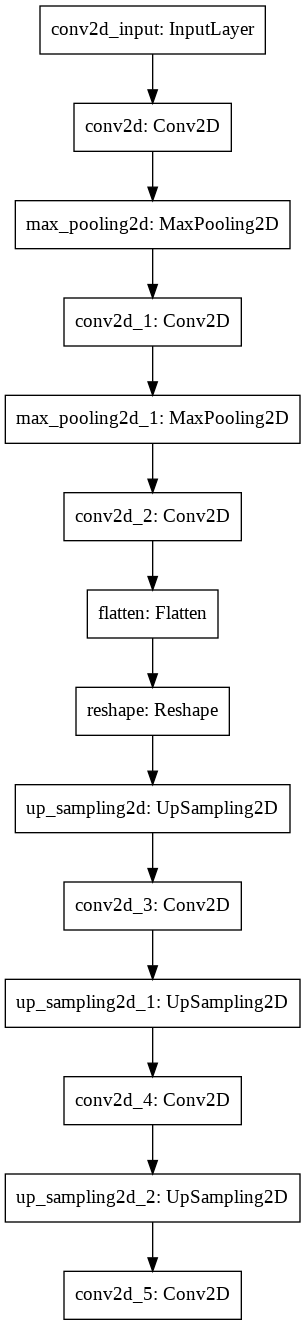

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session

clear_session()

input_dim = hs.shape[1:]

model = Sequential()

# Encoder layers
model.add(Conv2D(16,(3,3),activation='relu',padding="same",input_shape=input_dim))
model.add(MaxPooling2D((2,2),padding="same"))
model.add(Conv2D(8,(3,3),activation='relu',padding="same"))
model.add(MaxPooling2D((2,2),padding="same"))
model.add(Conv2D(8,(3,3),strides=(2,2),activation='relu',padding="same"))

# Flatten encoding for visualization, this is the bottleneck
model.add(Flatten())
model.add(Reshape((32, 32, 8)))

# Decoder layers
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(8,(3,3),activation='relu',padding="same"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(16,(3,3),activation='relu',padding="same"))
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(3,(3,3),activation='linear',padding="same"))


model.summary()
plot_model(model)

In [ ]:
model.compile(optimizer='adam', loss='mse')
model.fit(
      train_iterator,
      batch_size=16,
      epochs=10,
      steps_per_epoch=32,
      verbose=1)

Epoch 1/10
32/32 [==============================] - 55s 2s/step - loss: 8262.5332
Epoch 2/10
32/32 [==============================] - 54s 2s/step - loss: 6974.2642
Epoch 3/10
32/32 [==============================] - 54s 2s/step - loss: 6382.0151
Epoch 4/10
32/32 [==============================] - 54s 2s/step - loss: 5998.3374
Epoch 5/10
32/32 [==============================] - 54s 2s/step - loss: 6095.8516
Epoch 6/10
32/32 [==============================] - 54s 2s/step - loss: 5597.0146
Epoch 7/10
32/32 [==============================] - 54s 2s/step - loss: 5329.4302
Epoch 8/10
32/32 [==============================] - 54s 2s/step - loss: 4694.3999
Epoch 9/10
32/32 [==============================] - 54s 2s/step - loss: 3621.3718
Epoch 10/10
32/32 [==============================] - 54s 2s/step - loss: 3399.2498


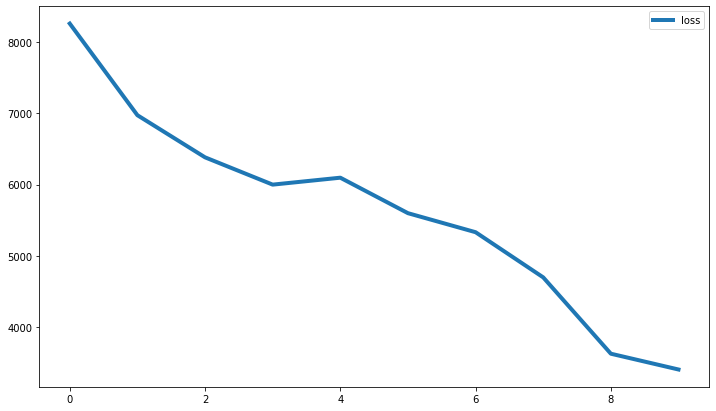

In [ ]:
history = model.history

plt.figure(figsize=(12,7))

plt.plot(history.history["loss"], lw=4, label="loss")

plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

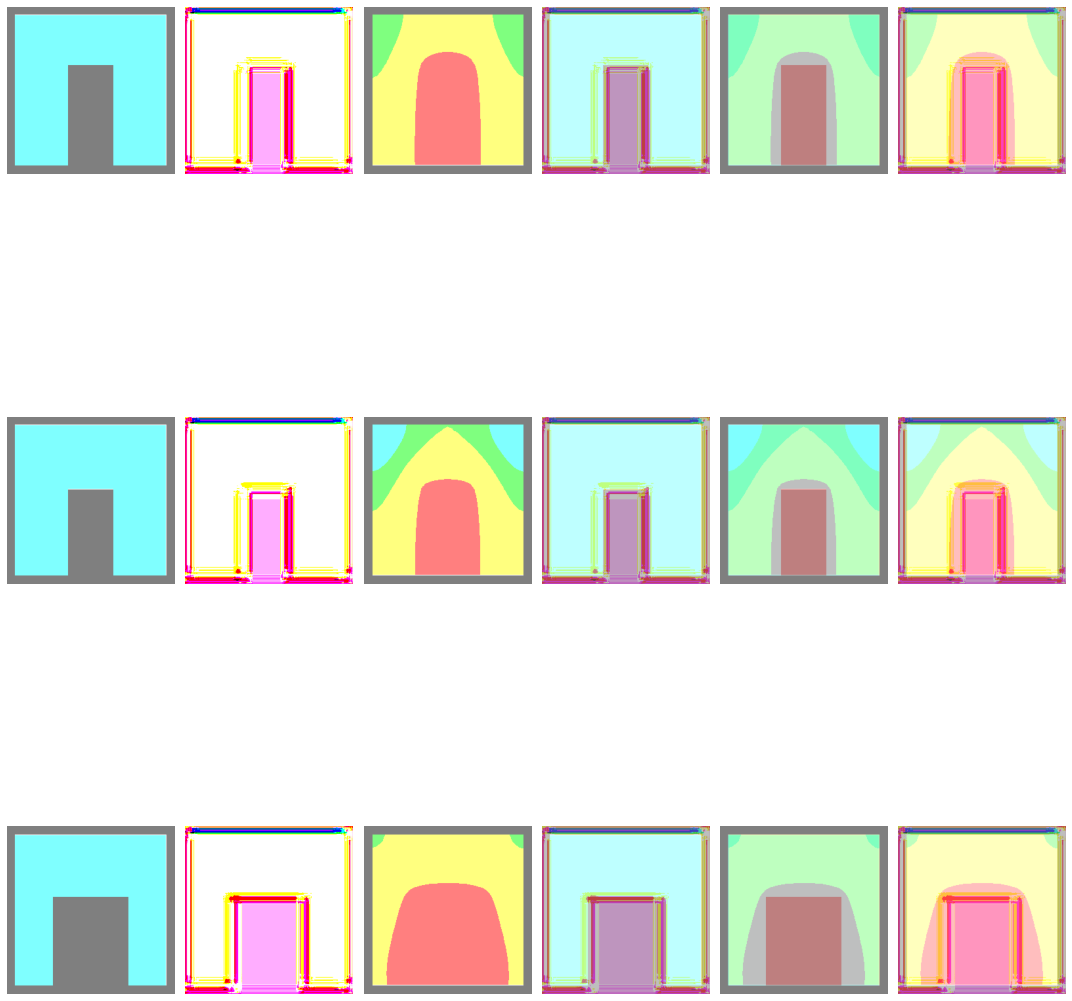

In [ ]:
samples = 3

fig,axs = plt.subplots(samples,6, figsize=(15,20))

gt_hat = model.predict(hs.reshape(-1,256,256,3))

for sample in range(samples):
    axs[sample,0].imshow((hs[sample]+1)/2)
    axs[sample,1].imshow(gt_hat[sample].reshape(256,256,3))
    axs[sample,2].imshow((gt[sample]+1)/2)
    axs[sample,3].imshow((hs[sample]+1)/2)
    axs[sample,3].imshow(gt_hat[sample].reshape(256,256,3),alpha=0.5)
    axs[sample,4].imshow((hs[sample]+1)/2)
    axs[sample,4].imshow((gt[sample]+1)/2,alpha=0.5)
    axs[sample,5].imshow((gt[sample]+1)/2)
    axs[sample,5].imshow(gt_hat[sample].reshape(256,256,3),alpha=0.5)
    
axs=axs.flatten()

for ax in axs:
    ax.axis("off")
    
plt.tight_layout()